In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from zonolayer import Zonolayer

### Dataset
1. Load dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength)
2. Scale and Intervalise the data, intervalisation method comes from [(Tretiak et al., 2023)](https://www.sciencedirect.com/science/article/pii/S0893608023000680)

In [7]:
concrete = fetch_ucirepo(id=165) 
df = pd.concat([concrete.data.features, concrete.data.targets], axis=1)
y = df["Concrete compressive strength"].values

def intervalise_cc_strength(y):
    n = len(y)
    Delta = np.abs(np.random.normal(loc=2, scale=1, size=n))
    b = np.random.uniform(-1, 1, size=n)
    m = y + b * Delta
    y_lower = m - Delta
    y_upper = m + Delta
    return pd.DataFrame({
        "y": y,
        "y_lower": y_lower,
        "y_upper": y_upper,
        "Delta": Delta,
        "b": b
    })

intervals = intervalise_cc_strength(y)
print("Interval Statistics:")
print(intervals.describe())

# Prepare features and targets
X = concrete.data.features.values
y_true = intervals["y"].values
y_lower = intervals["y_lower"].values
y_upper = intervals["y_upper"].values

# Train-test split
X_train, X_test, y_train, y_test, y_lower_train, y_lower_test, y_upper_train, y_upper_test = train_test_split(
    X, y_true, y_lower, y_upper, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train_scaled)
X_test_t = torch.FloatTensor(X_test_scaled)

print(f"\nTraining samples: {len(X_train_t)}")
print(f"Test samples: {len(X_test_t)}")
print(f"Input features: {X_train_t.shape[1]}")

Interval Statistics:
                 y      y_lower      y_upper        Delta            b
count  1030.000000  1030.000000  1030.000000  1030.000000  1030.000000
mean     35.817961    33.821810    37.792638     1.985414     0.002639
std      16.705742    16.809546    16.762855     0.951469     0.574147
min       2.330000    -1.157679     2.897208     0.001153    -0.996391
25%      23.710000    21.177892    25.198542     1.324175    -0.480832
50%      34.445000    32.823223    36.752715     1.972210    -0.010148
75%      46.135000    44.052248    47.705167     2.649654     0.486981
max      82.600000    82.228273    84.980276     5.194341     0.999998

Training samples: 824
Test samples: 206
Input features: 8


### Neural Network
Standard Nueral Network trained on the midpoints of the target Y-intervals

In [8]:
class CentreNet(nn.Module):
    def __init__(self, input_dim, latent_dim=16, hidden_dims=[16, 16]):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.Tanh()
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        self.latent_layer = nn.Linear(prev_dim, latent_dim)
        self.output_layer = nn.Linear(latent_dim, 1)
        
    def forward(self, x, return_latent=False):
        h = self.encoder(x)
        latent = self.latent_layer(h)
        output = self.output_layer(latent)
        
        if return_latent:
            return output, latent
        return output


input_dim = X_train_t.shape[1]
net = CentreNet(input_dim=input_dim)

# Use interval centres as training targets
y_centre_train = (y_lower_train + y_upper_train) / 2
y_centre_train_t = torch.FloatTensor(y_centre_train).reshape(-1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

print("\nTraining neural network...")
epochs = 7000
losses = []

for epoch in range(epochs):
    net.train()
    optimizer.zero_grad()
    
    outputs = net(X_train_t)
    loss = criterion(outputs, y_centre_train_t)
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Training neural network...
Epoch [50/7000], Loss: 1477.0950
Epoch [100/7000], Loss: 1163.3175
Epoch [150/7000], Loss: 616.0125
Epoch [200/7000], Loss: 289.3517
Epoch [250/7000], Loss: 167.9257
Epoch [300/7000], Loss: 125.2771
Epoch [350/7000], Loss: 105.2067
Epoch [400/7000], Loss: 97.1355
Epoch [450/7000], Loss: 92.7636
Epoch [500/7000], Loss: 89.1396
Epoch [550/7000], Loss: 85.4132
Epoch [600/7000], Loss: 81.0365
Epoch [650/7000], Loss: 74.7334
Epoch [700/7000], Loss: 65.9745
Epoch [750/7000], Loss: 56.1075
Epoch [800/7000], Loss: 48.3403
Epoch [850/7000], Loss: 42.9948
Epoch [900/7000], Loss: 39.4753
Epoch [950/7000], Loss: 36.9688
Epoch [1000/7000], Loss: 35.0319
Epoch [1050/7000], Loss: 33.4475
Epoch [1100/7000], Loss: 32.1173
Epoch [1150/7000], Loss: 30.9763
Epoch [1200/7000], Loss: 29.9604
Epoch [1250/7000], Loss: 29.0147
Epoch [1300/7000], Loss: 28.1264
Epoch [1350/7000], Loss: 27.3206
Epoch [1400/7000], Loss: 26.5914
Epoch [1450/7000], Loss: 25.9162
Epoch [1500/7000], Loss: 2

     pcost       dcost       gap    pres   dres   k/t
 0: -1.2879e-14 -8.6993e-12  8e+04  6e-01  2e+03  1e+00
 1:  4.4401e+01  4.7163e+01  1e+04  7e-02  2e+02  3e+00
 2:  3.9236e+01  3.9785e+01  2e+03  2e-02  5e+01  6e-01
 3:  3.5740e+01  3.6075e+01  1e+03  1e-02  3e+01  4e-01
 4:  3.6840e+01  3.7026e+01  6e+02  6e-03  2e+01  2e-01
 5:  3.3201e+01  3.3327e+01  4e+02  4e-03  1e+01  1e-01
 6:  2.8684e+01  2.8710e+01  8e+01  1e-03  3e+00  3e-02
 7:  2.5947e+01  2.5963e+01  4e+01  6e-04  2e+00  2e-02
 8:  2.6667e+01  2.6682e+01  4e+01  6e-04  2e+00  2e-02
 9:  2.5472e+01  2.5480e+01  2e+01  3e-04  8e-01  9e-03
10:  2.5360e+01  2.5366e+01  2e+01  2e-04  7e-01  6e-03
11:  2.4978e+01  2.4980e+01  7e+00  1e-04  3e-01  3e-03
12:  2.4955e+01  2.4957e+01  5e+00  8e-05  2e-01  2e-03
13:  2.4895e+01  2.4896e+01  3e+00  5e-05  1e-01  1e-03
14:  2.4842e+01  2.4842e+01  2e+00  2e-05  7e-02  5e-04
15:  2.4825e+01  2.4825e+01  9e-01  1e-05  4e-02  3e-04
16:  2.4815e+01  2.4815e+01  5e-01  6e-06  2e-02  

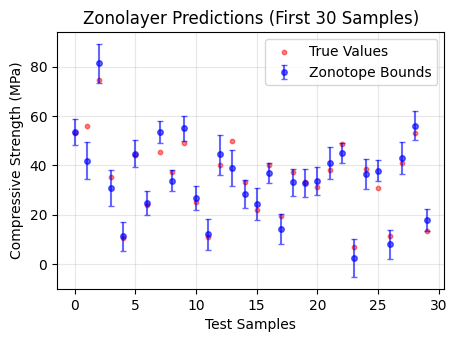

In [9]:
zl = Zonolayer(net, lambda_reg=1e-6, alpha=0.05)
results, ipm_upper, ipm_lower = zl.compute(
    x_train=X_train_t,
    x_test=X_test_t,
    y_lower=y_lower_train,
    y_upper=y_upper_train,
    ipm=True
)

# Extract results
y_centre_pred = results["pred_centre"].flatten()
y_lower_zono = results["y_lower_pred"].flatten()
y_upper_zono = results["y_upper_pred"].flatten()
pi_lower = results["pi_lower"].flatten()
pi_upper = results["pi_upper"].flatten()


fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot Zonolayer predictions as error bars
ax3 = fig.add_subplot(gs[1, 1])
test_indices_plot = np.arange(min(30, len(y_centre_pred)))  # First 100 test samples

y_centre_pred_plot = y_centre_pred[test_indices_plot]
y_lower_zono_plot = y_lower_zono[test_indices_plot]
y_upper_zono_plot = y_upper_zono[test_indices_plot]

ipm_lower_plot = ipm_lower.flatten()[test_indices_plot]
ipm_upper_plot = ipm_upper.flatten()[test_indices_plot]
ipm_centre_plot = (ipm_lower_plot + ipm_upper_plot) / 2

offset = 0.15
# ax3.errorbar(
#     test_indices_plot - offset,
#     ipm_centre_plot,
#     yerr=[ipm_centre_plot - ipm_lower_plot, 
#           ipm_upper_plot - ipm_centre_plot],
#     fmt='o', markersize=4, alpha=0.6, capsize=2, color='green', label='IPM Bounds'
# )

ax3.errorbar(
    test_indices_plot,
    y_centre_pred_plot,
    yerr=[y_centre_pred_plot - y_lower_zono_plot, 
          y_upper_zono_plot - y_centre_pred_plot],
    fmt='o', markersize=4, alpha=0.6, capsize=2, color='blue', label='Zonotope Bounds'
)
ax3.scatter(test_indices_plot, y_test[test_indices_plot], color='red', s=10, alpha=0.5, label='True Values')

ax3.set_xlabel('Test Samples')
ax3.set_ylabel('Compressive Strength (MPa)')
ax3.set_title('Zonolayer Predictions (First 30 Samples)')
ax3.legend()
ax3.grid(True, alpha=0.3)



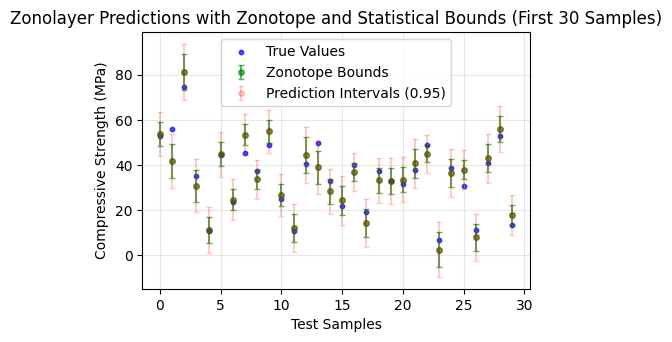

In [10]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax3 = fig.add_subplot(gs[1, 1])

# Select first 30 test samples
test_indices_plot = np.arange(min(30, len(y_centre_pred)))

# Slice predictions and bounds
y_centre_plot = y_centre_pred[test_indices_plot]
y_lower_zono_plot = y_lower_zono[test_indices_plot]
y_upper_zono_plot = y_upper_zono[test_indices_plot]
pi_lower_plot = pi_lower[test_indices_plot]
pi_upper_plot = pi_upper[test_indices_plot]
y_true_plot = y_test[test_indices_plot]

# Plot Zonotope bounds (blue error bars)
ax3.errorbar(
    test_indices_plot,
    y_centre_plot,
    yerr=[y_centre_plot - y_lower_zono_plot, y_upper_zono_plot - y_centre_plot],
    fmt='o', markersize=4, alpha=0.6, capsize=2, color='green', label='Zonotope Bounds'
)

# Plot Statistical Prediction Intervals (green error bars)
ax3.errorbar(
    test_indices_plot,
    y_centre_plot,
    yerr=[y_centre_plot - pi_lower_plot, pi_upper_plot - y_centre_plot],
    fmt='o', markersize=4, alpha=0.2, capsize=2, color='red', label='Prediction Intervals (0.95)'
)

# Scatter true values (red)
ax3.scatter(test_indices_plot, y_true_plot, color='blue', s=10, alpha=0.7, label='True Values')

# Labels and grid
ax3.set_xlabel('Test Samples')
ax3.set_ylabel('Compressive Strength (MPa)')
ax3.set_title('Zonolayer Predictions with Zonotope and Statistical Bounds (First 30 Samples)')
ax3.legend()
ax3.grid(True, alpha=0.3)
